## L3: Topic Models
### 732A92/TDDE16 Text Mining
Måns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stopwords. The code is implemented as a class, TopicModel, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

# __Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Sum up $\mathbf{z}$ to $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$)<br>
Sum up $\mathbf{z}$ to $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$)<br>
Sum up $\mathbf{z}$ to $\mathbf{n}$, the topic count vector of length ($K$)<br>

for $g \leftarrow 1$ __to__ _no_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ =- 1, $n^{(d)}_{d_i,z_i}$ =- 1, $n_{z_i}$ =- 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ =+ 1, $n^{(d)}_{d_i,z_i}$ =+ 1, $n_{z_i}$ =+ 1<br>
&emsp;&emsp;__end__<br>
__end__

In [1]:
import numpy, random, scipy.special
from tm3 import LDAGibbs

class MyGibbs(LDAGibbs):
    
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics)) #n_w
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics)) #n_d
        self.topic_totals = numpy.zeros(self.num_topics) #K
        self.doc_totals = numpy.zeros(self.num_docs) #D
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = list(map(lambda x: random.randrange(self.num_topics), doc['tokens']))
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for i in range(doc_length):
                token = doc['tokens'][i]
                topic = doc['topics'][i]
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
        ## Printout to check that everything is coherent
#         print(sum(sum(self.doc_topics)))
#         print(sum(sum(self.term_topics)))
#         print(sum(self.topic_totals))
#         print(sum(self.doc_totals))
        #print(self.term_topics)


    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        self.total_tokens=0 
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stoplist:
                        self.total_tokens += 1
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.doc_snippets.append(line[:200])
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
    
    def __init__(self,
                 num_topics,
                 docs_file_name,
                 stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.doc_snippets = []
        self.docs = []
        ## Prepare list of stopwords
        self.stoplist = dict()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stoplist[word] = 1
        self.read_documents(docs_file_name)
        self.initialize_matrices()
    
    def print_topics(self, j):
        """Prints topic distributions for the."""
        for i in range(self.term_topics.shape[1]):
            indexes = self.term_topics[:,i].argsort()[-j:][::-1] #top j
            z =[]
                        
            for number in indexes:
                
                z.append("{} [{}]".format(self.vocab[number], self.term_topics[number,i]))
            print(" ,".join(z))
        #super().print_topics(j)
            
    def make_draw(self, alpha, beta):
        """Makes a single draw from the posterior distribution in an MCMC fashion."""
            
        for doc_id in range(self.num_docs):
            
            doc = self.docs[doc_id]
            doc_length = len(doc['tokens'])
            for i in range(doc_length):
                token = doc['tokens'][i]
                topic = doc['topics'][i]
                self.term_topics[token][topic] -= 1 # n_wk
                self.doc_topics[doc_id][topic] -= 1 # n_dk
                self.topic_totals[topic] -= 1       # n_k
                p = numpy.zeros(self.num_topics)
                for k in range(self.num_topics):
                        num = (alpha + self.doc_topics[doc_id][k])*(beta + self.term_topics[token][k])
                        den =(self.num_terms*beta+ self.topic_totals[k])
                        prob = num/den
                        p[k]= prob
                p = p/sum(p)
                number = numpy.argmax(numpy.random.multinomial(1,p))
                
                self.docs[doc_id]['topics'][i] = number
                self.term_topics[token][number] += 1 # n_wk
                self.doc_topics[doc_id][number] += 1 # n_dk
                self.topic_totals[number] += 1       # n_k

        

        #super().make_draw(alpha, beta)
    
    def compute_logprob(self, alpha, beta):
        """Computes the log marginal posterior."""
        return super().compute_logprob(alpha, beta)
    
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations):
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def plot(self):
        super().plot()
        
    def new_speech(self, N):
        alpha = 0.5
        beta = 0.01
        ### Creating the frequencies
        Word = []
        freqMat =  numpy.zeros((self.num_terms, self.num_topics))
        for i in range(self.term_topics.shape[1]):
            freqMat[:,i] = (self.term_topics[:,i]+beta)/(self.term_topics[:,i]+self.num_terms*beta)
            freqMat[:,i] = (freqMat[:,i]/sum(freqMat[:,i]))        
            
            # Draw a vector of topic 
        theta = numpy.random.dirichlet([alpha]*self.num_topics)
        for n in range(N):
            index = numpy.argmax(theta) #gets the indices for the topic choice
            number = numpy.argmax(numpy.random.multinomial(1,freqMat[:,index])) # gets the index for the word choice
            Word.append(self.vocab[number])
        print(Word)    

In [2]:
"""
import numpy
a = numpy.arange(15).reshape(3, 5)
b = numpy.array(["a","b","c","d","e","f","g","h","i","j","k","l", "m", "n", "o"])
c =b.reshape(3,5)
print(c)
print(a)
matRes =  numpy.zeros((3, 3))
print(matRes)
for i in range(a.shape[1]):
    indices = a[:,i].argsort()[-3:][::-1]#top 3
    z =[]
    for j in indices:
        z .append("{} [{}]".format(c[j,i], a[j,i]))
    print(" ,".join(z))
# This is an example for me
matRes2 =  numpy.zeros((3, 5))
for i in range(a.shape[1]):
    matRes2[:,i] = (a[:,i]/sum(a[:,i]))
print(matRes2)
"""## This is just for myself, not for evaluation

'import numpy\na = numpy.arange(15).reshape(3, 5)\nb = numpy.array(["a","b","c","d","e","f","g","h","i","j","k","l", "m", "n", "o"])\nc =b.reshape(3,5)\nprint(c)\nprint(a)\nmatRes =  numpy.zeros((3, 3))\nprint(matRes)\nfor i in range(a.shape[1]):\n    indices = a[:,i].argsort()[-3:][::-1]#top 3\n    z =[]\n    for j in indices:\n        z .append("{} [{}]".format(c[j,i], a[j,i]))\n    print(" ,".join(z))\n# This is an example for me\nmatRes2 =  numpy.zeros((3, 5))\nfor i in range(a.shape[1]):\n    matRes2[:,i] = (a[:,i]/sum(a[:,i]))\nprint(matRes2)\n'

Implement the make_draw function above. You should get behavior very similar to the results from calling the parent class.

In [3]:
model = MyGibbs(10, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.make_draw(0.1,0.01)
model.run(10)


Read 2898 documents with a total of 8695 terms
iteration 0, -9.847850075443736
iteration 1, -9.591933629843115
iteration 2, -9.431132744460886
iteration 3, -9.319797477492186
iteration 4, -9.217988142533063
iteration 5, -9.150567425490532
iteration 6, -9.089751625013093
iteration 7, -9.045914196771813
iteration 8, -8.99822896788592
iteration 9, -8.960876418962842


### 2. Top terms
Implement the print_topics function to extract the top j largest counts in n (w) by row. This is the most probable word types in each topic.

In [4]:
model.print_topics(10)

america [192.0] ,people [148.0] ,world [109.0] ,children [104.0] ,freedom [92.0] ,congress [85.0] ,american [83.0] ,work [79.0] ,tonight [74.0] ,americans [73.0]
energy [121.0] ,policy [83.0] ,america [71.0] ,years [65.0] ,administration [58.0] ,act [58.0] ,past [54.0] ,world [49.0] ,development [49.0] ,economic [49.0]
work [91.0] ,children [86.0] ,make [86.0] ,health [85.0] ,care [76.0] ,century [67.0] ,congress [64.0] ,government [58.0] ,people [58.0] ,education [55.0]
america [97.0] ,years [96.0] ,year [76.0] ,american [75.0] ,percent [65.0] ,million [50.0] ,tonight [46.0] ,high [44.0] ,major [42.0] ,world [39.0]
world [87.0] ,soviet [61.0] ,countries [60.0] ,united [58.0] ,international [57.0] ,war [55.0] ,oil [52.0] ,states [49.0] ,east [47.0] ,relations [46.0]
people [82.0] ,national [71.0] ,policy [49.0] ,work [48.0] ,support [43.0] ,rights [43.0] ,america [42.0] ,laws [42.0] ,year [38.0] ,defense [38.0]
tax [99.0] ,people [93.0] ,family [83.0] ,work [69.0] ,americans [67.0] ,fa

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

iteration 0, -8.92604788080609
iteration 1, -8.88987244508865
iteration 2, -8.86830749986855
iteration 3, -8.837239823808988
iteration 4, -8.814139654950175
iteration 5, -8.796394665483717
iteration 6, -8.78050283221805
iteration 7, -8.757690019492287
iteration 8, -8.734965169254654
iteration 9, -8.717590131849379
iteration 10, -8.70087564024808
iteration 11, -8.684355491718883
iteration 12, -8.66805192828962
iteration 13, -8.65572998226685
iteration 14, -8.64231445063438
iteration 15, -8.636307696249654
iteration 16, -8.620956086999971
iteration 17, -8.612400630133138
iteration 18, -8.606515875416052
iteration 19, -8.593879144429208
iteration 20, -8.587514258482368
iteration 21, -8.579600778032189
iteration 22, -8.567966003824937
iteration 23, -8.557615418990265
iteration 24, -8.556661799172653
iteration 25, -8.546474272593258
iteration 26, -8.540487383923141
iteration 27, -8.534992832436584
iteration 28, -8.527919041606811
iteration 29, -8.520299194412244
iteration 30, -8.51366343600

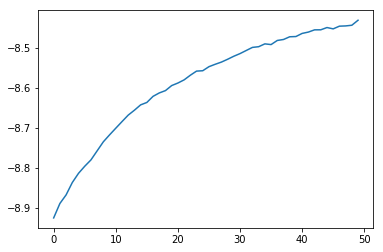

In [5]:
%matplotlib inline
model.run(50)
model.plot()

#### Answer here: Apparently, after 50 iterations it seems to converge around -8.4, ,meaning that the words that define the topics are the good ones, and that not much changes there will be anymore

### 4. Simulate a new State of the Union speech

Write a function new_speech in the MyGibbs class to use the estimated values for $\Phi$ from your model (with stopwords removed) to simulate a new State of the Union speech. Start out by simulating $\theta d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [6]:
model.new_speech(N = 100)

['leading', 'applied', 'nation', 'fellow', 'prosper', 'generation', 'possibility', 'century', 'make', 'planet', 'renewed', 'replaced', 'american', 'decide', 'future', 'signs', 'state', 'helped', 'hand', 'hopes', 'idea', 'material', 'back', 'make', 'time', 'tonight', 'path', 'children', 'peace', 'sense', 'change', 'transform', 'rooted', 'stop', 'families', 'set', 'show', 'veteran', 'rest', 'dole', 'single', 'freshman', 'threatening', 'vision', 'nicaragua', 'suzann', 'interests', 'blessings', 'wonderful', 'carry', 'greatest', 'europeans', 'great', 'primary', 'reflection', 'greatest', 'black', 'time', 'left', 'prison', 'america', 'giant', 'members', 'vivid', 'shared', 'seek', 'opportunity', 'eye', 'state', 'sort', 'human', 'find', 'native', 'fellow', 'built', 'compassion', 'president', 'create', 'people', 'bless', 'enrichment', 'world', 'divided', 'ordinary', 'dreams', 'obey', 'ready', 'dreams', 'forget', 'constitution', 'moral', 'newcomer', 'people', 'literally', 'hope', 'gave', 'men', '

#### Answer here: It looks like the words it appears make sense since it looks like is vocabular for a new State of Union Speech.

### Bonus assignment:

To get better understanding of the underlying model, you might want to implement your own function to compute the log marginal posterior. If so, implement the compute_logprob function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).